We consider steady-state flow in a fully saturated porous medium. We will assume constant porosity and viscosity for simplicity, leading to Darcy's law producing a flux $$ q = -\kappa \nabla p $$ in terms of pressure $p$ and permeability $\kappa$. Conservation of mass yields a Laplacian 
$$ \nabla\cdot q = -\nabla\cdot \big( \kappa \nabla p \big) = 0 . $$
The velocity of the fluid is 
$$ u = \frac q \phi $$ 
where $\phi \in (0,1]$ is porosity.

Our flow will take place on the 2D unit disc with two holes removed 
$$ \left\{ x \in \mathbb R^2 : |x|<1, \big|x-(1/2,0)\big|>1/4, \big|x-(-1/2,0)\big| > 1/4  \right\} . $$ The outer boundary is Neumann, corresponding to an impermeable boundary. The left "hole" is our inejection with a relative pressure of 1 and the right is extraction with a relative pressure of 0.

The velocity field can be computed by taking the gradient of pressure and dividing by permeability. Now suppose that the fluid being injected at the left hole is hot while the outflow is a colder heat sink. Temperature will satisfy the advection-diffusion equation (with appropriate choice of units) 
$$ \nabla\cdot \big( - \nabla T + u T \big) = 0 $$ 
with boundary conditions $T=1$ at the left (inflow) hole, $T=0$ at the right (outflow) hole, and Neumann conditions at the (insulated) outer boundary. The homework is to solve for temperature using the velocity field defined by the pressure solution above.

- You will need to modify fe2_solve so that you can evaluate velocity at the quadrature points.
- You will need to write a form function that implements the weak form of the advection-diffusion equation for temperature.

In [1]:
%matplotlib inline
import numpy
from matplotlib import pyplot
pyplot.style.use('ggplot')

import scipy.sparse as sp
import scipy.sparse.linalg
from scipy.optimize import fsolve

%run mesh.py
%run fe2tri.py
%run fe2solve.py

Laplasian equation for pressure:
$$ -\nabla\cdot \big( \kappa \nabla p \big) = 0 . $$
which gives
$$ f_0 = 0,\quad f_1 = \kappa \nabla p.$$

In [2]:
class laplacian_pressure:
    def __init__(self, k=0.5):
        self.k = k
    def form(self, x, u, Du, Dp):
        return (0, self.k*Du), ((0, 0), (0, self.k*numpy.eye(2)[None,:,:]))

In [3]:
def fsolve_newton(F, J, u0, rtol=1e-10, maxit=50, verbose=False):
    u = u0.copy()
    Fu = F(u)
    norm0 = numpy.linalg.norm(Fu)
    for i in range(maxit):
        du = sp.linalg.spsolve(J(u), -Fu)
        u += du
        Fu = F(u)
        norm = numpy.linalg.norm(Fu)
        if verbose:
            print('Newton {:d} anorm {:6.2e} rnorm {:6.2e}'.
                  format(i+1, norm, norm/norm0))
        if norm < rtol * norm0:
            break
    return u, i

def fe2_geom(fe, mesh):
    x, Erestrict = mesh.Erestrict(fe.p)
    nelem = len(Erestrict)
    Q = len(fe.w)
    B, D = fe.B, fe.D
    W = numpy.empty((nelem, Q))
    dXdx = numpy.empty((nelem, Q, 2, 2))
    xq = numpy.empty((nelem, Q, 2))
    for e, E in enumerate(Erestrict):
        xE = x[E,:]
        xq[e] = B @ xE
        dxdX = D @ xE # 2x2 matrices at each quadrature point
        det = numpy.linalg.det(dxdX)
        W[e] = w * det # Quadrature weight on physical element
        dXdx[e] = numpy.linalg.inv(dxdX)
    return xq, W, dXdx

def fe2_solve(fe, mesh, form, pres=None, dirichlet={}, spy=False):
    x, Erestrict = mesh.Erestrict(fe.p)
    Frestrict = mesh.Frestrict(fe.p)
    Ndof = len(x)
    if pres is None:
        pres = numpy.zeros(Ndof)
    B, D = fe.B, fe.D
    xq, W, dXdx = fe2_geom(fe, mesh)
    dirichletidx = []
    bcmask = numpy.zeros(Ndof, dtype=bool)
    for label, func in dirichlet.items():
        indices = Frestrict[mesh.boundary[label]].flatten()
        dirichletidx.append((label, indices, func))
        bcmask[indices] = True

    def project_dirichlet(u): # Affine projector into space satisfying Dirichlet BC
        ubc = u.copy()
        for label, indices, func in dirichletidx:
            ubc[indices] = func(x[indices])
        return ubc

    def residual(u):
        ubc = project_dirichlet(u)
        v = u - ubc
        for e, E in enumerate(Erestrict):
            uE = ubc[E]
            pE = pres[E]  #pressure at quadrature points
            uq = B @ uE
            Dxuq = numpy.einsum('ixX,iX->ix', dXdx[e], D @ uE)
            Dxpq = numpy.einsum('ixX,iX->ix', dXdx[e], D @ pE)  # gradient of pressure
            f, _ = form(xq[e], uq, Dxuq, Dxpq)
            vE = B.T @ (W[e] * f[0]) + numpy.einsum('iXp,ixX,ix->p', 
                                                    D, dXdx[e], W[e,:,None] * f[1])
            vE[bcmask[E]] = 0
            v[E] += vE
        return v

    def jacobian(u):
        ubc = project_dirichlet(u)
        ai = []
        aj = []
        aa = []
        for e, E in enumerate(Erestrict):
            uE = ubc[E]
            pE = pres[E]    # pressure at quadrature points
            Dx = numpy.einsum('ixX,iXp->ixp', dXdx[e], D)
            _, df = form(xq[e], B @ uE, Dx @ uE, Dx @ pE)
            Ae = (numpy.einsum('qi,q,qj->ij', B, W[e] * df[0][0], B)
                  + numpy.einsum('qi,qy,qyj->ij', B, W[e,:,None] * df[0][1], Dx)
                  + numpy.einsum('qxi,qx,qj->ij', Dx, W[e,:,None] * df[1][0], B)
                  + numpy.einsum('qxi,qxy,qyj->ij', Dx, W[e,:,None,None] * df[1][1], Dx))
            Ae[bcmask[E],:] = 0
            Ae[:,bcmask[E]] = 0
            ai += numpy.outer(E, numpy.ones_like(E)).flatten().tolist()
            aj += numpy.outer(numpy.ones_like(E), E).flatten().tolist()
            aa += Ae.flatten().tolist()
        bcidx = numpy.where(bcmask)[0].tolist()
        ai += bcidx
        aj += bcidx
        aa += numpy.ones_like(bcidx).tolist()
        A = sp.csr_matrix((aa, (ai, aj)), shape=(Ndof,Ndof))
        if spy:
            pyplot.spy(A)
        return A

    u0 = numpy.zeros(Ndof) # initial guess
    u, nit = fsolve_newton(residual, jacobian, u0, verbose=True)
    return x, u

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 6.07e-15 rnorm 8.23e-16


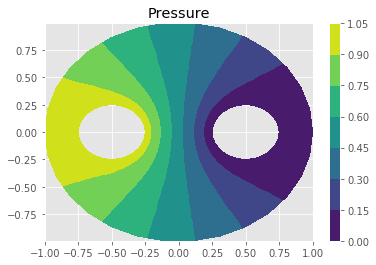

In [4]:
mesh = Mesh(shape='eyes', reshape_boundary=True)
fe = fe2tri(2)
prob = laplacian_pressure()
x, pressure = fe2_solve(fe, mesh, prob.form, dirichlet=dict(left=lambda x:0*x[:,0]+1, right=lambda x:0*x[:,0]))
pyplot.tricontourf(x[:,0], x[:,1], pressure, triangles=mesh.tri2())
pyplot.title('Pressure')
pyplot.colorbar();

Laplacian equation for temperature:
$$ \nabla\cdot \big( - \nabla T + u T \big) = 0 $$ 
$$ -\nabla\cdot \big( \nabla T + \frac{\kappa}{\phi}\nabla p T \big) = 0, $$ 
which gives
$$ f_0 = 0,\quad f_1 =  \nabla T + \frac{\kappa}{\phi}\nabla p T.$$
$$ \frac{\partial f_1}{\partial T} = \frac{\kappa}{\phi}\nabla p, \quad \frac{\partial f_1}{\partial (\nabla T)} = 1 $$

In [5]:
class laplacian_temperature:
    def __init__(self, k=0.5, phi=1):
        self.k = k
        self.phi = phi
    def form(self, x, u, Du, Dp):
        return ((0, Du+self.k/self.phi*Dp*u.reshape(-1,1)), 
                ((0, 0), (self.k/self.phi*Dp, numpy.eye(2)[None,:,:])))

Newton 1 anorm 1.54e-14 rnorm 1.32e-15


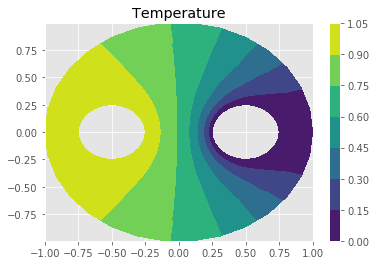

In [6]:
prob_t = laplacian_temperature(k = 1, phi = 0.5)
x, temperature = fe2_solve(fe, mesh, prob_t.form, pres=pressure,
                           dirichlet=dict(left=lambda x:0*x[:,0]+1, right=lambda x:0*x[:,0]))
pyplot.tricontourf(x[:,0], x[:,1], temperature, triangles=mesh.tri2())
pyplot.title('Temperature')
pyplot.colorbar();

## 1)
What is the order of accuracy of $p$, $u$, and $T$ for linear fe2tri(1) and quadratic fe2tri(2) elements? Rather than interpolating to compare in a norm, you can compare by computing moments of the error, such as $$ \int_\Omega x (u_{2h} - u_h)(x,y) = \int_\Omega x u_{2h}(x,y) - \int_\Omega x u_h(x,y), $$ where the two integrals on the right can be carried out on the natural quadrature of each mesh independently.

Given the reference coordinates $X \in K \subset R^n$ and physical coordinates $x(X)$ on the physical element $x(K)$, an integral on the physical element can be written
$$ \int_{x(K)} f(x) dx = \int_K \underbrace{\left\lvert \frac{\partial x}{\partial X} \right\rvert}_{\text{determinant}} f(x(X)) dX .$$
Therefore,
$$ \int_{x(K)} x u(x) dx = \int_K \underbrace{\left\lvert \frac{\partial x}{\partial X} \right\rvert}_{\text{determinant}} x(X) u(x(X)) dX .$$
$$ \sum_e \mathcal E_e^T  B^T W \left\lvert \frac{\partial x}{\partial X} \right\rvert x u $$

In [7]:
print(x.shape, pressure.shape, temperature.shape)
print()

(430, 2) (430,) (430,)



In [8]:
def calc_momonents(u, fe):
    x, Erestrict = mesh.Erestrict(fe.p)
    B = fe.B
    xq, W, dXdx = fe2_geom(fe, mesh)
    isum = 0
    for e, E in enumerate(Erestrict):
        isum += numpy.sum(W[e] * (B @ u[E]) * numpy.abs(xq[e][:,1]))
#         uE = u[E]    # value at quadrature points
#         Ae = numpy.einsum('qi,qj->ij', B, W[e] * uE)
# #         * numpy.abs(xq[e][:,1])
#         isum += Ae.flatten().tolist()
    return isum

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 1.65e-14 rnorm 1.28e-15
Newton 1 anorm 4.19e-14 rnorm 2.45e-15
    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 7.84e-15 rnorm 8.59e-16
Newton 1 anorm 2.02e-14 rnorm 1.66e-15
    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 3.98e-15 rnorm 6.14e-16
Newton 1 anorm 9.86e-15 rnorm 1.16e-15
    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 2.40e-15 rnorm 4.88e-16
Newton 1 anorm 4.67e-15 rnorm 6.86e-16
    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 9.16e-16 rnorm 2.47e-16
Newton 1 anorm 2.65e-15 rnorm 4.63e-16
[ 0.00125312  0.00421726  0.01377082  0.05125019]
[ 0.00191119  0.00634165  0.02104495  0.07485207]


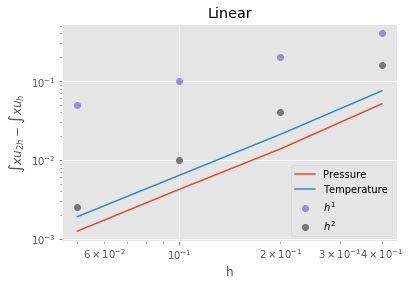

In [9]:
fe = fe2tri(1)
h = numpy.array([0.05, 0.1, 0.2, 0.4])
m_pres = numpy.empty(len(h))
m_temp  = numpy.empty_like(m_pres)

for i, h_i in enumerate(h):
    mesh = Mesh(shape='eyes', lcar=h_i, reshape_boundary=True)
    
    prob = laplacian_pressure()
    x, pressure = fe2_solve(fe, mesh, prob.form, dirichlet=dict(left=lambda x:0*x[:,0]+1, right=lambda x:0*x[:,0]))
    m_pres[i] = calc_momonents(pressure, fe)
    
    prob_t = laplacian_temperature(k = 1, phi = 0.5)
    x, temperature = fe2_solve(fe, mesh, prob_t.form, pres=pressure,
                           dirichlet=dict(left=lambda x:0*x[:,0]+1, right=lambda x:0*x[:,0]))
    m_temp[i] = calc_momonents(temperature, fe)

diff_m_pres = m_pres[:-1]-m_pres[1:]
diff_m_temp = m_temp[:-1]-m_temp[1:]
print(diff_m_pres)
print(diff_m_temp)
pyplot.loglog(h[:-1], diff_m_pres, label="Pressure")
pyplot.loglog(h[:-1], diff_m_temp, label="Temperature")
pyplot.loglog(h[:-1], numpy.power(h[:-1], 1.0), 'o', label="$h^{1}$")
pyplot.loglog(h[:-1], numpy.power(h[:-1], 2.0), 'o', label="$h^{2}$")
pyplot.ylabel("$\int xu_{2h} - \int x u_{h}$")
pyplot.xlabel("h")
pyplot.title("Linear")
pyplot.legend();

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 5.82e-14 rnorm 2.91e-15
Newton 1 anorm 1.52e-13 rnorm 5.19e-15
    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 2.59e-14 rnorm 1.83e-15
Newton 1 anorm 6.82e-14 rnorm 3.30e-15
    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 1.18e-14 rnorm 1.19e-15
Newton 1 anorm 3.08e-14 rnorm 2.17e-15
    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 6.40e-15 rnorm 8.40e-16
Newton 1 anorm 1.75e-14 rnorm 1.52e-15
    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 3.20e-15 rnorm 5.39e-16
Newton 1 anorm 7.73e-15 rnorm 7.84e-16
[  5.82043162e-06   2.28349850e-05   2.70275419e-05   8.21015408e-04]
[  6.41230635e-06   2.86821277e-05   6.02420661e-05   1.68833438e-03]


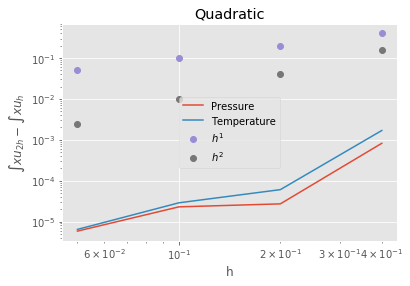

In [10]:
fe = fe2tri(2)
h = numpy.array([0.05, 0.1, 0.2, 0.4])
m_pres = numpy.empty(len(h))
m_temp  = numpy.empty_like(m_pres)

for i, h_i in enumerate(h):
    mesh = Mesh(shape='eyes', lcar=h_i, reshape_boundary=True)
    
    prob = laplacian_pressure()
    x, pressure = fe2_solve(fe, mesh, prob.form, dirichlet=dict(left=lambda x:0*x[:,0]+1, right=lambda x:0*x[:,0]))
    m_pres[i] = calc_momonents(pressure, fe)
    
    prob_t = laplacian_temperature(k = 1, phi = 0.5)
    x, temperature = fe2_solve(fe, mesh, prob_t.form, pres=pressure,
                           dirichlet=dict(left=lambda x:0*x[:,0]+1, right=lambda x:0*x[:,0]))
    m_temp[i] = calc_momonents(temperature, fe)

diff_m_pres = m_pres[:-1]-m_pres[1:]
diff_m_temp = m_temp[:-1]-m_temp[1:]
print(diff_m_pres)
print(diff_m_temp)
pyplot.loglog(h[:-1], diff_m_pres, label="Pressure")
pyplot.loglog(h[:-1], diff_m_temp, label="Temperature")
pyplot.loglog(h[:-1], numpy.power(h[:-1], 1.0), 'o', label="$h^{1}$")
pyplot.loglog(h[:-1], numpy.power(h[:-1], 2.0), 'o', label="$h^{2}$")
pyplot.ylabel("$\int xu_{2h} - \int x u_{h}$")
pyplot.xlabel("h")
pyplot.title("Quadratic")
pyplot.legend();

## 2)
When porosity $\phi$ decreases (at fixed permeability), the velocity increases. Can you obtain an accurate solution for $T$ for any value of $\phi$ or is there a relationship between $\phi$ and the grid size $h$?

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 5.76e-15 rnorm 7.81e-16
Newton 1 anorm 6.52e-13 rnorm 1.02e-14


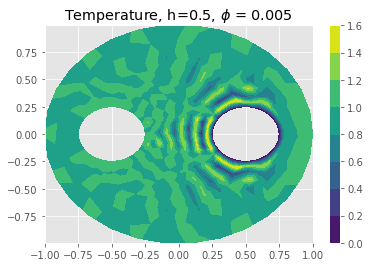

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 5.79e-15 rnorm 7.85e-16
Newton 1 anorm 3.07e-13 rnorm 8.39e-15


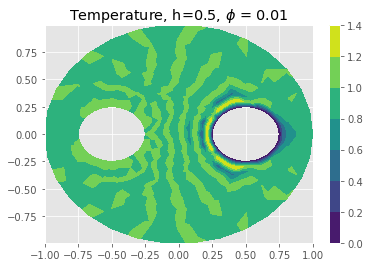

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 5.41e-15 rnorm 7.33e-16
Newton 1 anorm 1.85e-13 rnorm 6.70e-15


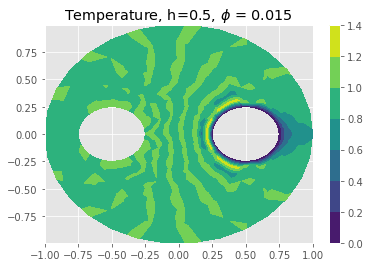

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 6.07e-15 rnorm 8.23e-16
Newton 1 anorm 1.50e-13 rnorm 6.47e-15


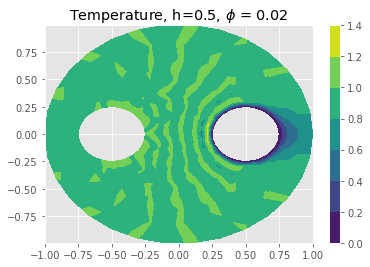

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 5.87e-15 rnorm 7.95e-16
Newton 1 anorm 1.17e-13 rnorm 5.66e-15


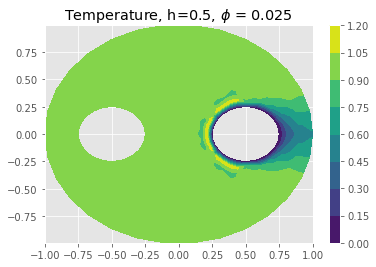

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 5.87e-15 rnorm 7.95e-16
Newton 1 anorm 9.99e-14 rnorm 5.27e-15


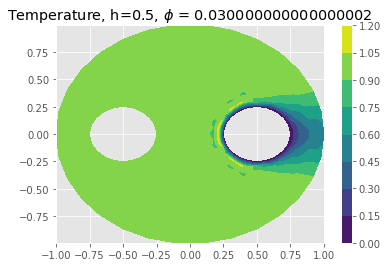

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 5.87e-15 rnorm 7.95e-16
Newton 1 anorm 8.54e-14 rnorm 4.80e-15


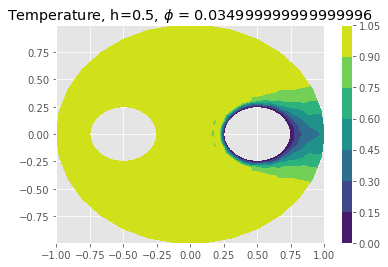

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 5.87e-15 rnorm 7.95e-16
Newton 1 anorm 7.60e-14 rnorm 4.50e-15


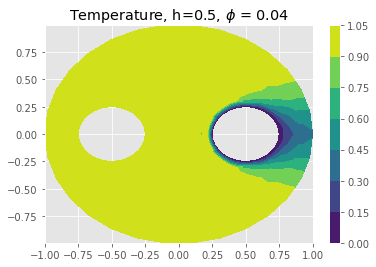

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 5.87e-15 rnorm 7.95e-16
Newton 1 anorm 6.56e-14 rnorm 4.04e-15


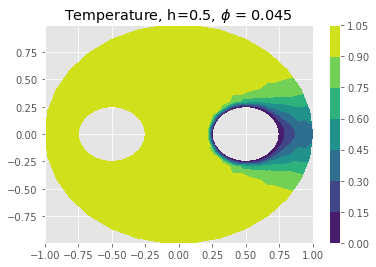

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 5.87e-15 rnorm 7.95e-16
Newton 1 anorm 6.00e-14 rnorm 3.82e-15


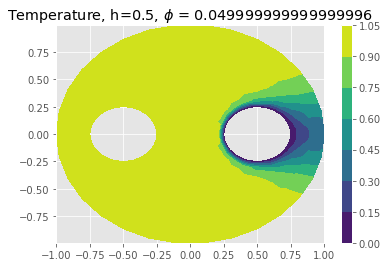

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 5.87e-15 rnorm 7.95e-16
Newton 1 anorm 5.50e-14 rnorm 3.61e-15


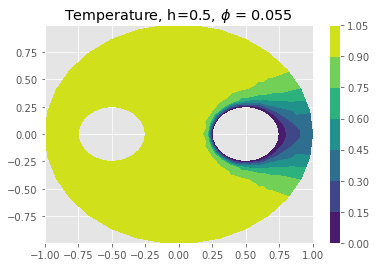

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 6.07e-15 rnorm 8.23e-16
Newton 1 anorm 5.38e-14 rnorm 3.61e-15


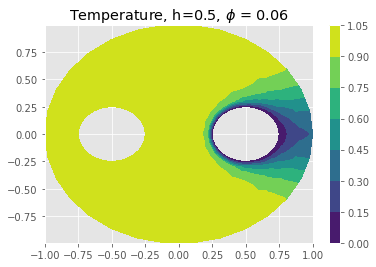

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 5.87e-15 rnorm 7.95e-16
Newton 1 anorm 4.94e-14 rnorm 3.38e-15


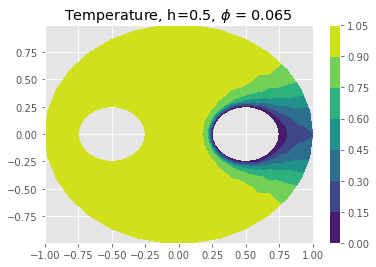

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 6.07e-15 rnorm 8.23e-16
Newton 1 anorm 4.65e-14 rnorm 3.24e-15


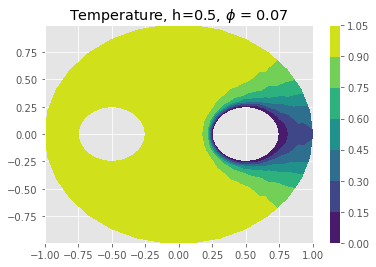

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 6.07e-15 rnorm 8.23e-16
Newton 1 anorm 4.27e-14 rnorm 3.02e-15


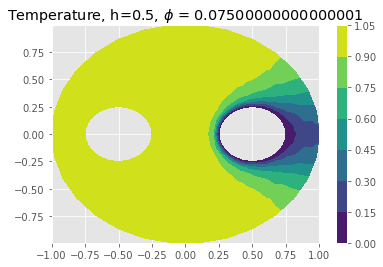

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 5.76e-15 rnorm 7.81e-16
Newton 1 anorm 4.60e-14 rnorm 3.30e-15


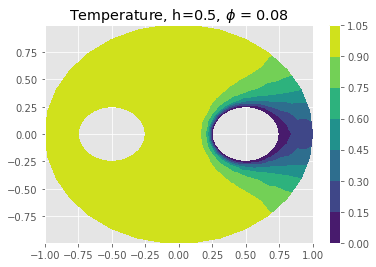

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 6.07e-15 rnorm 8.23e-16
Newton 1 anorm 4.07e-14 rnorm 2.95e-15


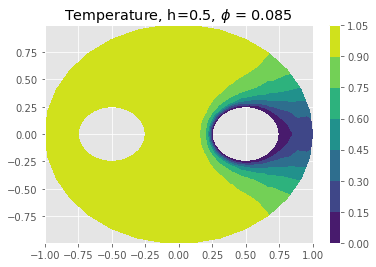

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 5.54e-15 rnorm 7.51e-16
Newton 1 anorm 3.60e-14 rnorm 2.64e-15


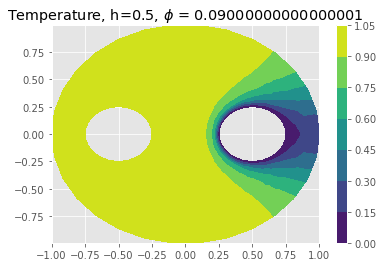

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 5.79e-15 rnorm 7.85e-16
Newton 1 anorm 3.74e-14 rnorm 2.77e-15


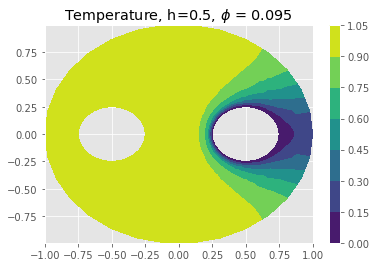

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 5.76e-15 rnorm 7.81e-16
Newton 1 anorm 3.68e-14 rnorm 2.75e-15


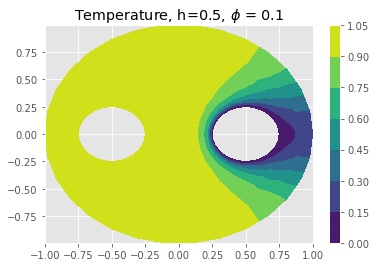

In [46]:
phi_all = numpy.linspace(0.005,0.1, 20)
h = 0.5
for j,phi in enumerate(phi_all):
#     m_temp = numpy.empty(len(h))
#     for i, h_i in enumerate(h):
    mesh = Mesh(shape='eyes', lcar=h, reshape_boundary=True)

    prob = laplacian_pressure()
    x, pressure = fe2_solve(fe, mesh, prob.form, 
                            dirichlet=dict(left=lambda x:0*x[:,0]+1, right=lambda x:0*x[:,0]))

    prob_t = laplacian_temperature(k = 1, phi = phi)
    x, temperature = fe2_solve(fe, mesh, prob_t.form, pres=pressure,
                           dirichlet=dict(left=lambda x:0*x[:,0]+1, right=lambda x:0*x[:,0]))
    pyplot.tricontourf(x[:,0], x[:,1], temperature, triangles=mesh.tri2())
    pyplot.title('Temperature, h={}, $\phi$ = {}'.format(h,phi))
    pyplot.colorbar();
    pyplot.show()

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 6.27e-15 rnorm 8.23e-16
Newton 1 anorm 3.35e-13 rnorm 9.91e-15


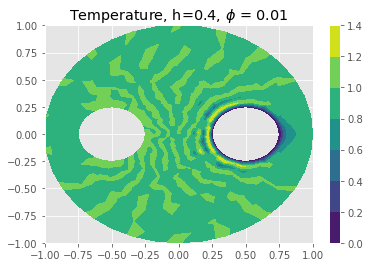

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 6.27e-15 rnorm 8.23e-16
Newton 1 anorm 1.73e-13 rnorm 7.91e-15


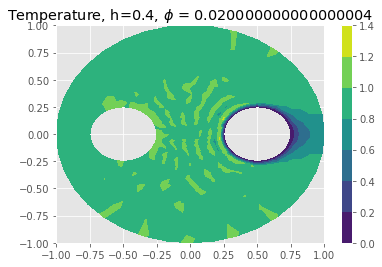

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 6.27e-15 rnorm 8.23e-16
Newton 1 anorm 1.17e-13 rnorm 6.51e-15


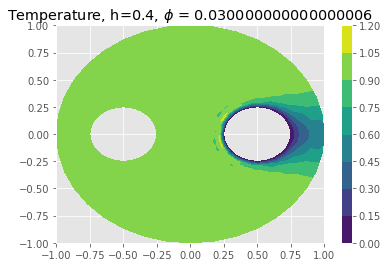

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 6.27e-15 rnorm 8.23e-16
Newton 1 anorm 8.97e-14 rnorm 5.55e-15


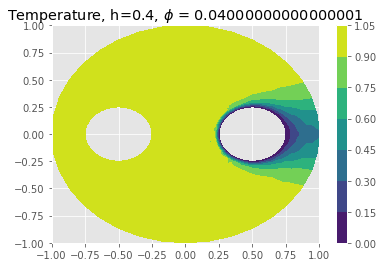

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 6.27e-15 rnorm 8.23e-16
Newton 1 anorm 7.06e-14 rnorm 4.68e-15


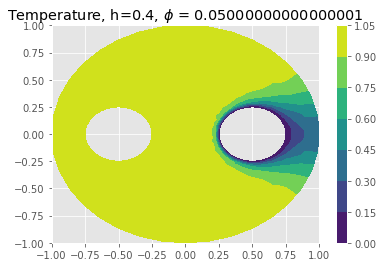

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 6.27e-15 rnorm 8.23e-16
Newton 1 anorm 6.14e-14 rnorm 4.27e-15


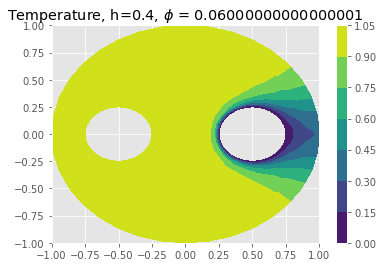

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 6.40e-15 rnorm 8.40e-16
Newton 1 anorm 5.05e-14 rnorm 3.64e-15


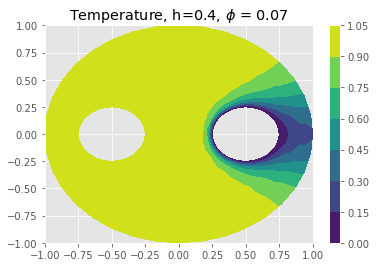

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 6.27e-15 rnorm 8.23e-16
Newton 1 anorm 4.71e-14 rnorm 3.48e-15


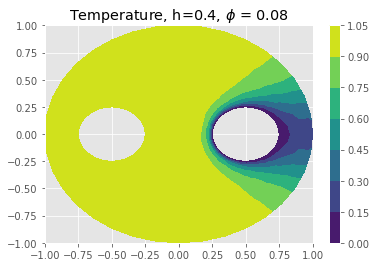

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 6.27e-15 rnorm 8.23e-16
Newton 1 anorm 4.30e-14 rnorm 3.25e-15


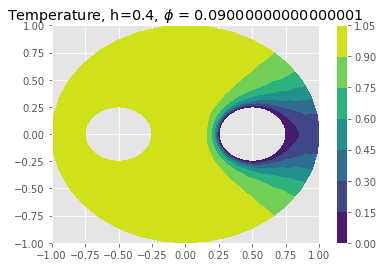

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 5.99e-15 rnorm 7.86e-16
Newton 1 anorm 4.03e-14 rnorm 3.10e-15


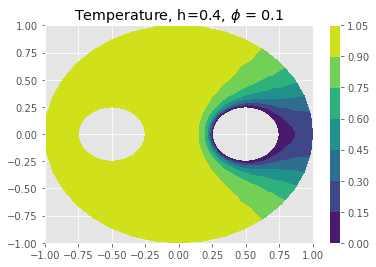

In [47]:
phi_all = numpy.linspace(0.01,0.1, 20)
h = 0.4
for j,phi in enumerate(phi_all):
#     m_temp = numpy.empty(len(h))
#     for i, h_i in enumerate(h):
    mesh = Mesh(shape='eyes', lcar=h, reshape_boundary=True)

    prob = laplacian_pressure()
    x, pressure = fe2_solve(fe, mesh, prob.form, 
                            dirichlet=dict(left=lambda x:0*x[:,0]+1, right=lambda x:0*x[:,0]))

    prob_t = laplacian_temperature(k = 1, phi = phi)
    x, temperature = fe2_solve(fe, mesh, prob_t.form, pres=pressure,
                           dirichlet=dict(left=lambda x:0*x[:,0]+1, right=lambda x:0*x[:,0]))
    pyplot.tricontourf(x[:,0], x[:,1], temperature, triangles=mesh.tri2())
    pyplot.title('Temperature, h={}, $\phi$ = {}'.format(h,phi))
    pyplot.colorbar();
    pyplot.show()

In [48]:
## h=0.4 phi = 0.05

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 6.69e-15 rnorm 8.79e-16
Newton 1 anorm 1.09e-13 rnorm 6.07e-15


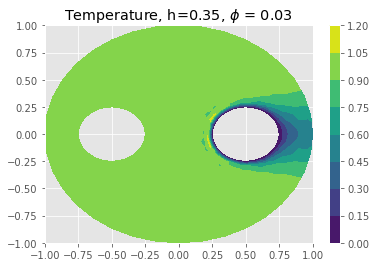

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 6.78e-15 rnorm 8.91e-16
Newton 1 anorm 1.11e-13 rnorm 6.24e-15


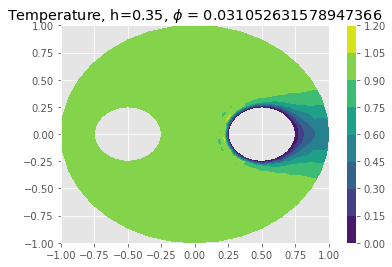

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 6.64e-15 rnorm 8.71e-16
Newton 1 anorm 1.13e-13 rnorm 6.47e-15


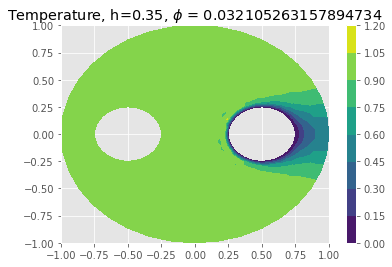

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 6.78e-15 rnorm 8.91e-16
Newton 1 anorm 1.03e-13 rnorm 5.96e-15


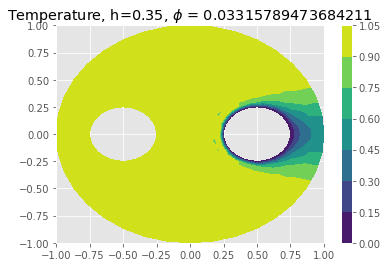

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 6.44e-15 rnorm 8.45e-16
Newton 1 anorm 9.97e-14 rnorm 5.83e-15


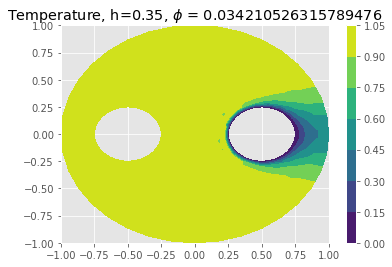

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 6.69e-15 rnorm 8.79e-16
Newton 1 anorm 9.24e-14 rnorm 5.47e-15


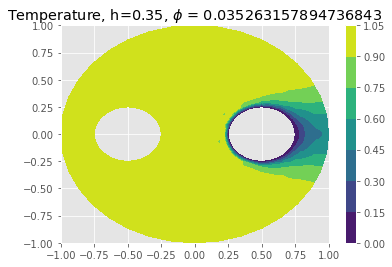

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 6.69e-15 rnorm 8.79e-16
Newton 1 anorm 9.08e-14 rnorm 5.43e-15


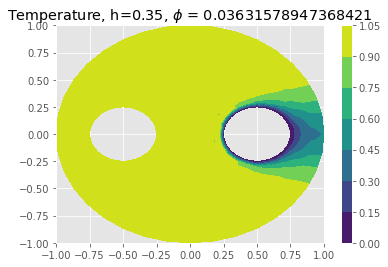

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 6.69e-15 rnorm 8.79e-16
Newton 1 anorm 9.04e-14 rnorm 5.47e-15


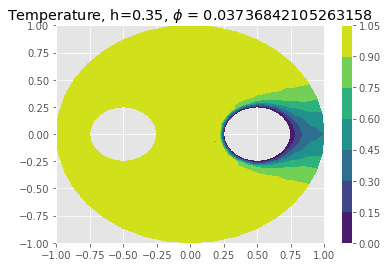

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 6.78e-15 rnorm 8.91e-16
Newton 1 anorm 9.01e-14 rnorm 5.50e-15


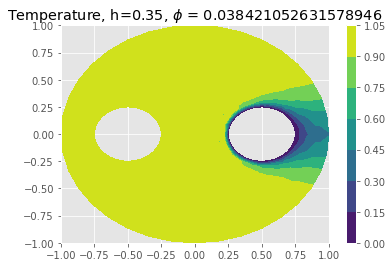

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 6.69e-15 rnorm 8.79e-16
Newton 1 anorm 8.55e-14 rnorm 5.27e-15


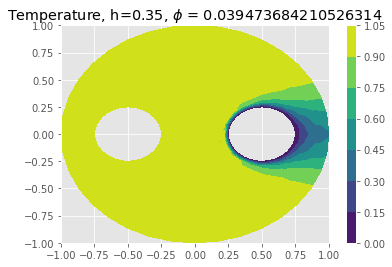

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 6.44e-15 rnorm 8.45e-16
Newton 1 anorm 8.54e-14 rnorm 5.31e-15


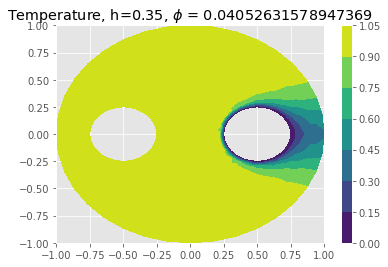

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 6.78e-15 rnorm 8.91e-16
Newton 1 anorm 8.66e-14 rnorm 5.43e-15


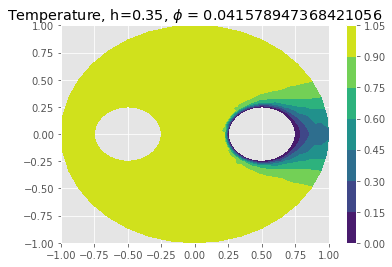

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 6.78e-15 rnorm 8.91e-16
Newton 1 anorm 8.18e-14 rnorm 5.17e-15


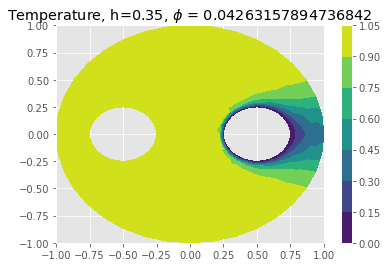

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 6.69e-15 rnorm 8.79e-16
Newton 1 anorm 7.88e-14 rnorm 5.02e-15


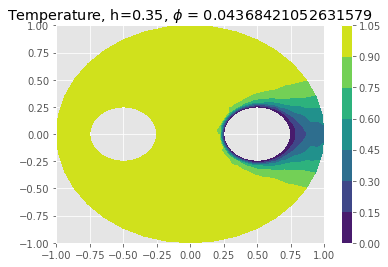

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 6.69e-15 rnorm 8.79e-16
Newton 1 anorm 7.73e-14 rnorm 4.96e-15


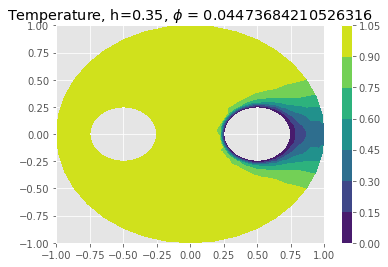

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 6.78e-15 rnorm 8.91e-16
Newton 1 anorm 7.53e-14 rnorm 4.87e-15


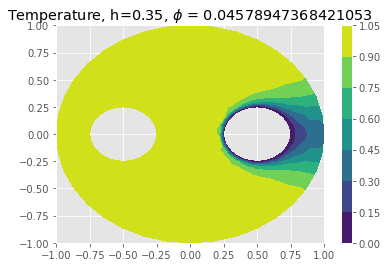

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 6.69e-15 rnorm 8.79e-16
Newton 1 anorm 7.18e-14 rnorm 4.67e-15


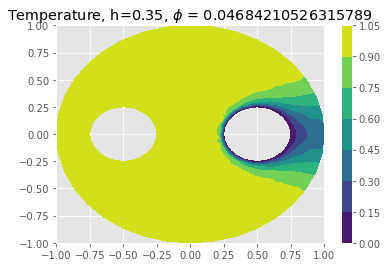

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 6.78e-15 rnorm 8.91e-16
Newton 1 anorm 7.46e-14 rnorm 4.89e-15


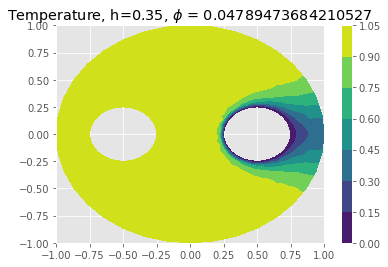

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 6.45e-15 rnorm 8.47e-16
Newton 1 anorm 6.89e-14 rnorm 4.54e-15


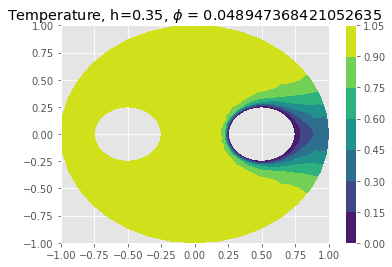

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 6.64e-15 rnorm 8.71e-16
Newton 1 anorm 7.36e-14 rnorm 4.88e-15


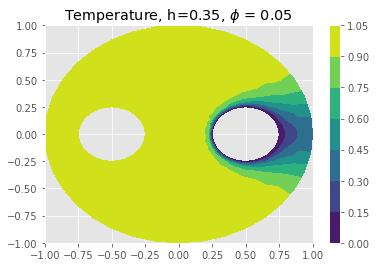

In [90]:
phi_all = numpy.linspace(0.03,0.05, 20)
h = 0.35
for j,phi in enumerate(phi_all):
#     m_temp = numpy.empty(len(h))
#     for i, h_i in enumerate(h):
    mesh = Mesh(shape='eyes', lcar=h, reshape_boundary=True)

    prob = laplacian_pressure()
    x, pressure = fe2_solve(fe, mesh, prob.form, 
                            dirichlet=dict(left=lambda x:0*x[:,0]+1, right=lambda x:0*x[:,0]))

    prob_t = laplacian_temperature(k = 1, phi = phi)
    x, temperature = fe2_solve(fe, mesh, prob_t.form, pres=pressure,
                           dirichlet=dict(left=lambda x:0*x[:,0]+1, right=lambda x:0*x[:,0]))
    pyplot.tricontourf(x[:,0], x[:,1], temperature, triangles=mesh.tri2())
    pyplot.title('Temperature, h={}, $\phi$ = {}'.format(h,phi))
    pyplot.colorbar();
    pyplot.show()

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 7.13e-15 rnorm 8.86e-16
Newton 1 anorm 3.93e-13 rnorm 1.20e-14


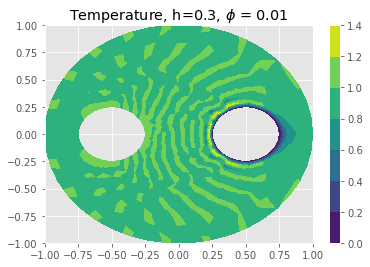

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 8.11e-15 rnorm 1.01e-15
Newton 1 anorm 2.86e-13 rnorm 9.94e-15


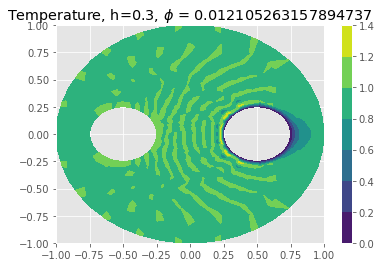

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 7.85e-15 rnorm 9.75e-16
Newton 1 anorm 2.79e-13 rnorm 1.07e-14


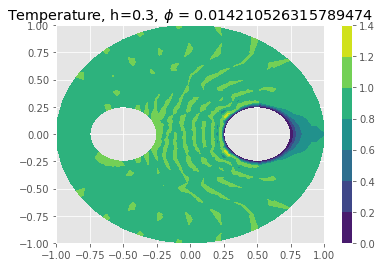

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 7.05e-15 rnorm 8.76e-16
Newton 1 anorm 2.31e-13 rnorm 9.63e-15


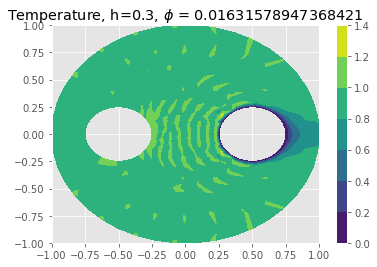

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 7.13e-15 rnorm 8.86e-16
Newton 1 anorm 2.18e-13 rnorm 9.68e-15


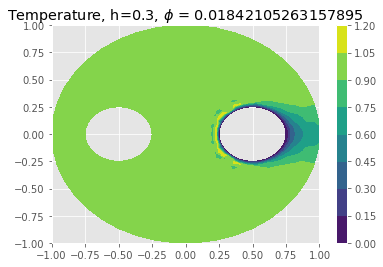

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 7.13e-15 rnorm 8.86e-16
Newton 1 anorm 1.92e-13 rnorm 9.04e-15


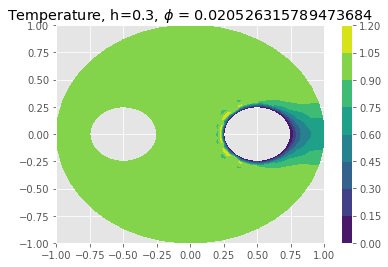

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 7.13e-15 rnorm 8.86e-16
Newton 1 anorm 1.77e-13 rnorm 8.73e-15


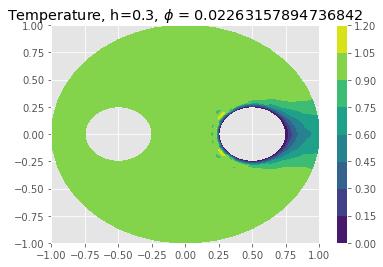

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 7.13e-15 rnorm 8.86e-16
Newton 1 anorm 1.62e-13 rnorm 8.29e-15


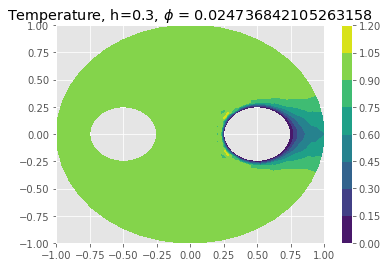

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 7.85e-15 rnorm 9.75e-16
Newton 1 anorm 1.52e-13 rnorm 8.08e-15


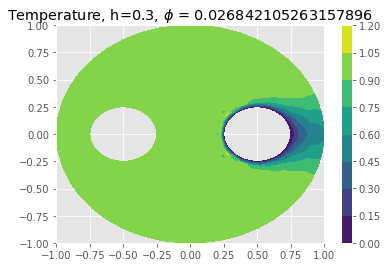

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 6.74e-15 rnorm 8.38e-16
Newton 1 anorm 1.27e-13 rnorm 6.93e-15


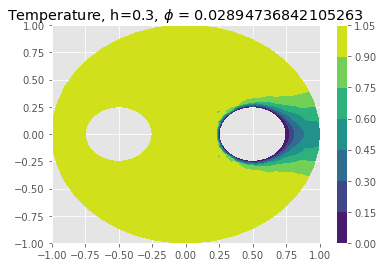

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 7.13e-15 rnorm 8.86e-16
Newton 1 anorm 1.31e-13 rnorm 7.40e-15


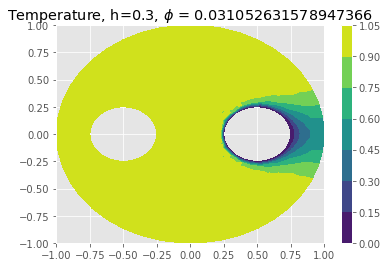

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 7.64e-15 rnorm 9.50e-16
Newton 1 anorm 1.16e-13 rnorm 6.69e-15


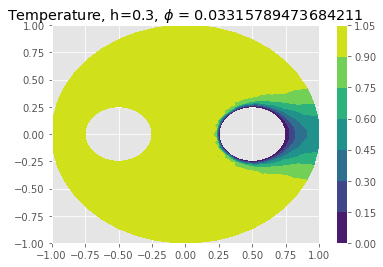

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 7.13e-15 rnorm 8.86e-16
Newton 1 anorm 1.18e-13 rnorm 6.94e-15


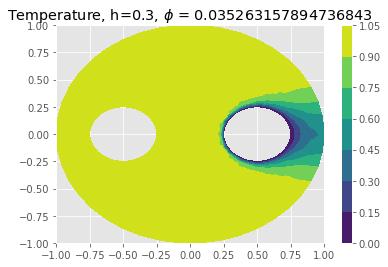

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 8.25e-15 rnorm 1.03e-15
Newton 1 anorm 1.07e-13 rnorm 6.46e-15


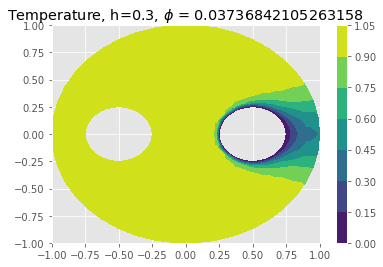

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 7.94e-15 rnorm 9.86e-16
Newton 1 anorm 9.99e-14 rnorm 6.12e-15


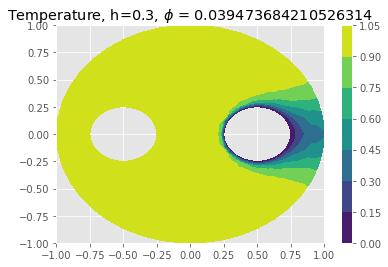

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 7.13e-15 rnorm 8.86e-16
Newton 1 anorm 9.84e-14 rnorm 6.12e-15


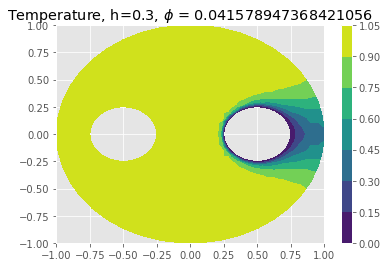

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 7.30e-15 rnorm 9.08e-16
Newton 1 anorm 8.81e-14 rnorm 5.56e-15


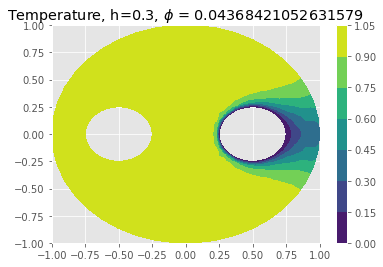

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 7.13e-15 rnorm 8.86e-16
Newton 1 anorm 9.01e-14 rnorm 5.77e-15


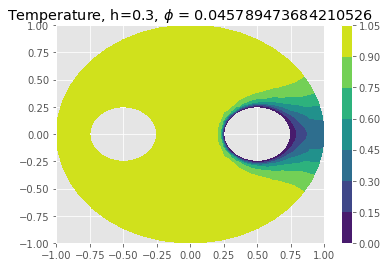

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 7.13e-15 rnorm 8.86e-16
Newton 1 anorm 8.80e-14 rnorm 5.70e-15


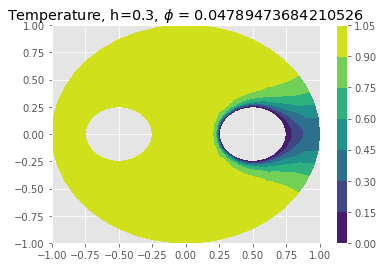

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 7.13e-15 rnorm 8.86e-16
Newton 1 anorm 8.33e-14 rnorm 5.46e-15


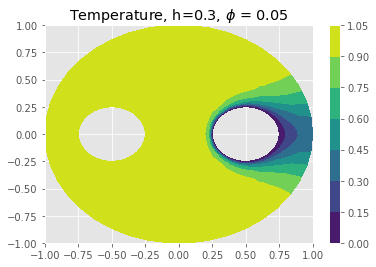

In [49]:
phi_all = numpy.linspace(0.01,0.05, 20)
h = 0.3
for j,phi in enumerate(phi_all):
#     m_temp = numpy.empty(len(h))
#     for i, h_i in enumerate(h):
    mesh = Mesh(shape='eyes', lcar=h, reshape_boundary=True)

    prob = laplacian_pressure()
    x, pressure = fe2_solve(fe, mesh, prob.form, 
                            dirichlet=dict(left=lambda x:0*x[:,0]+1, right=lambda x:0*x[:,0]))

    prob_t = laplacian_temperature(k = 1, phi = phi)
    x, temperature = fe2_solve(fe, mesh, prob_t.form, pres=pressure,
                           dirichlet=dict(left=lambda x:0*x[:,0]+1, right=lambda x:0*x[:,0]))
    pyplot.tricontourf(x[:,0], x[:,1], temperature, triangles=mesh.tri2())
    pyplot.title('Temperature, h={}, $\phi$ = {}'.format(h,phi))
    pyplot.colorbar();
    pyplot.show()

## h = 0.3, phi = 0.033

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 1.28e-14 rnorm 1.30e-15
Newton 1 anorm 5.75e-12 rnorm 2.90e-14


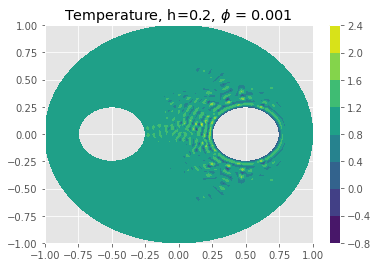

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 1.28e-14 rnorm 1.30e-15
Newton 1 anorm 1.35e-12 rnorm 2.46e-14


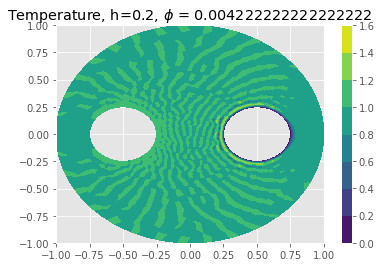

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 1.28e-14 rnorm 1.30e-15
Newton 1 anorm 7.69e-13 rnorm 2.12e-14


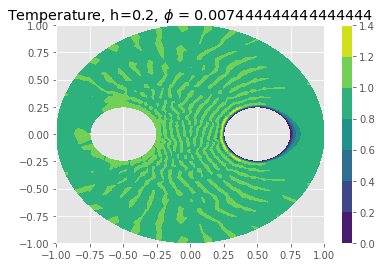

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 1.28e-14 rnorm 1.30e-15
Newton 1 anorm 5.39e-13 rnorm 1.85e-14


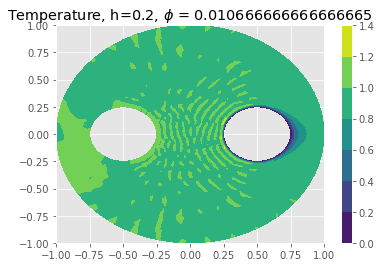

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 1.18e-14 rnorm 1.19e-15
Newton 1 anorm 4.03e-13 rnorm 1.59e-14


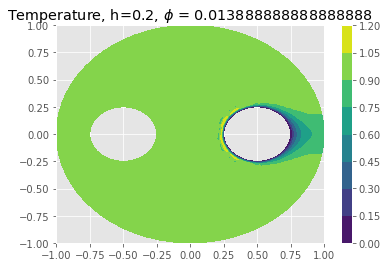

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 1.19e-14 rnorm 1.20e-15
Newton 1 anorm 3.35e-13 rnorm 1.46e-14


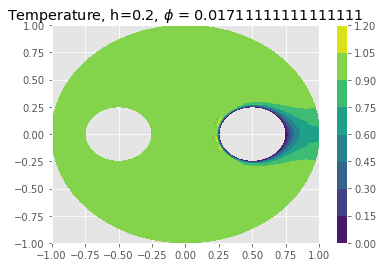

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 1.28e-14 rnorm 1.30e-15
Newton 1 anorm 2.88e-13 rnorm 1.34e-14


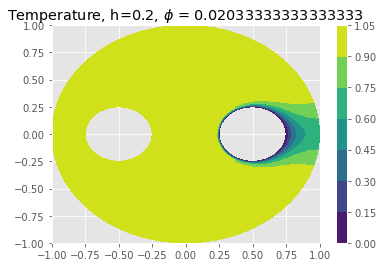

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 1.28e-14 rnorm 1.30e-15
Newton 1 anorm 2.49e-13 rnorm 1.22e-14


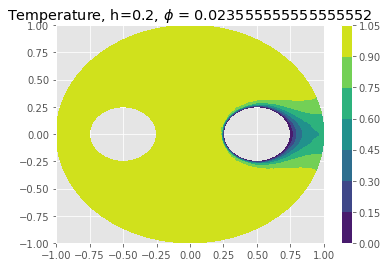

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 1.18e-14 rnorm 1.19e-15
Newton 1 anorm 2.11e-13 rnorm 1.09e-14


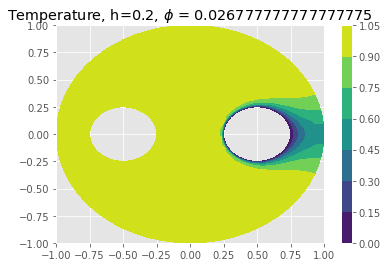

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 1.18e-14 rnorm 1.19e-15
Newton 1 anorm 1.92e-13 rnorm 1.02e-14


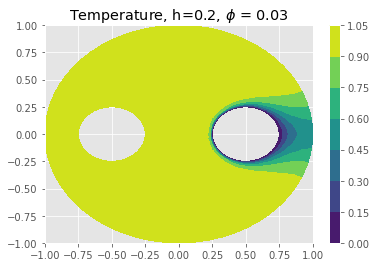

In [51]:
phi_all = numpy.linspace(0.001,0.03, 10)
h = 0.2
for j,phi in enumerate(phi_all):
#     m_temp = numpy.empty(len(h))
#     for i, h_i in enumerate(h):
    mesh = Mesh(shape='eyes', lcar=h, reshape_boundary=True)

    prob = laplacian_pressure()
    x, pressure = fe2_solve(fe, mesh, prob.form, 
                            dirichlet=dict(left=lambda x:0*x[:,0]+1, right=lambda x:0*x[:,0]))

    prob_t = laplacian_temperature(k = 1, phi = phi)
    x, temperature = fe2_solve(fe, mesh, prob_t.form, pres=pressure,
                           dirichlet=dict(left=lambda x:0*x[:,0]+1, right=lambda x:0*x[:,0]))
    pyplot.tricontourf(x[:,0], x[:,1], temperature, triangles=mesh.tri2())
    pyplot.title('Temperature, h={}, $\phi$ = {}'.format(h,phi))
    pyplot.colorbar();
    pyplot.show()

In [52]:
## h = 0.2 phi = 0.02

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 2.70e-14 rnorm 1.91e-15
Newton 1 anorm 1.11e-11 rnorm 7.16e-14


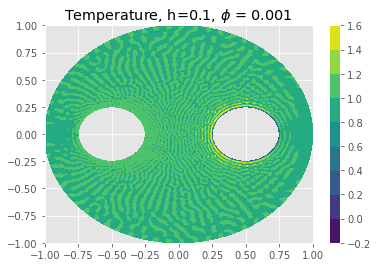

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 2.59e-14 rnorm 1.83e-15
Newton 1 anorm 3.59e-12 rnorm 5.88e-14


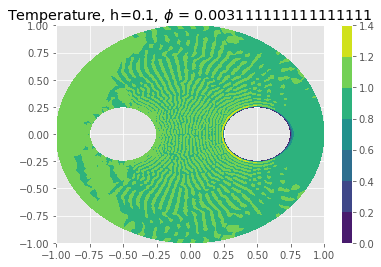

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 2.66e-14 rnorm 1.89e-15
Newton 1 anorm 2.11e-12 rnorm 4.82e-14


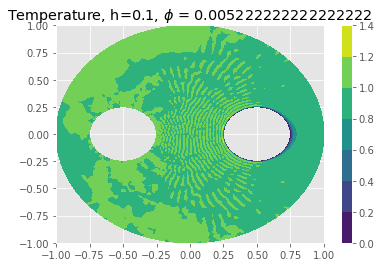

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 2.55e-14 rnorm 1.81e-15
Newton 1 anorm 1.49e-12 rnorm 4.07e-14


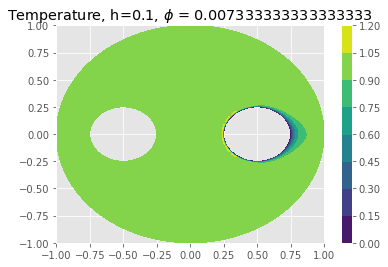

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 2.60e-14 rnorm 1.84e-15
Newton 1 anorm 1.21e-12 rnorm 3.70e-14


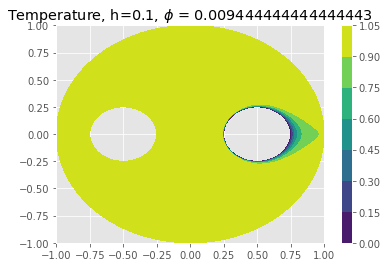

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 2.54e-14 rnorm 1.80e-15
Newton 1 anorm 9.65e-13 rnorm 3.19e-14


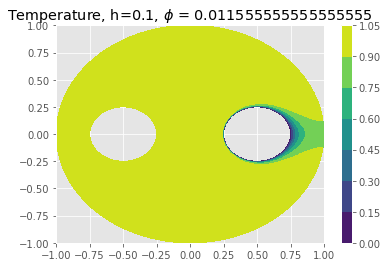

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 2.60e-14 rnorm 1.84e-15
Newton 1 anorm 8.38e-13 rnorm 2.93e-14


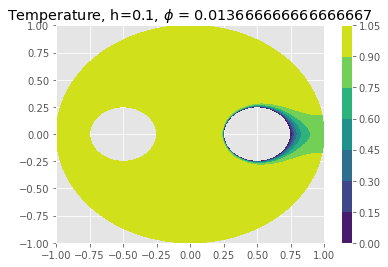

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 2.59e-14 rnorm 1.83e-15
Newton 1 anorm 7.17e-13 rnorm 2.61e-14


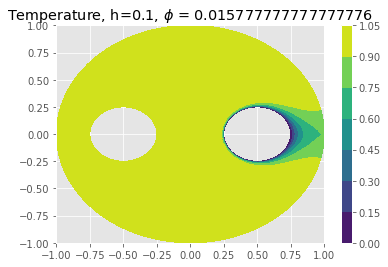

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 2.57e-14 rnorm 1.82e-15
Newton 1 anorm 6.21e-13 rnorm 2.34e-14


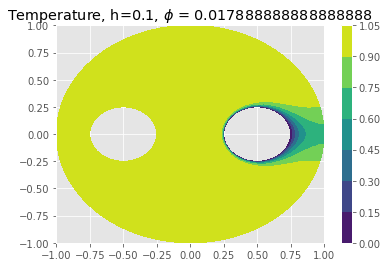

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 2.71e-14 rnorm 1.92e-15
Newton 1 anorm 5.81e-13 rnorm 2.25e-14


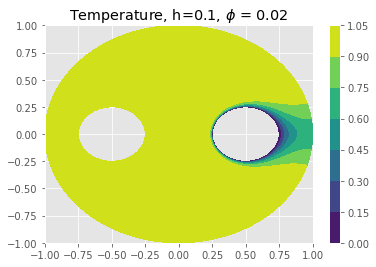

In [53]:
phi_all = numpy.linspace(0.001,0.02, 10)
h = 0.1
for j,phi in enumerate(phi_all):
#     m_temp = numpy.empty(len(h))
#     for i, h_i in enumerate(h):
    mesh = Mesh(shape='eyes', lcar=h, reshape_boundary=True)

    prob = laplacian_pressure()
    x, pressure = fe2_solve(fe, mesh, prob.form, 
                            dirichlet=dict(left=lambda x:0*x[:,0]+1, right=lambda x:0*x[:,0]))

    prob_t = laplacian_temperature(k = 1, phi = phi)
    x, temperature = fe2_solve(fe, mesh, prob_t.form, pres=pressure,
                           dirichlet=dict(left=lambda x:0*x[:,0]+1, right=lambda x:0*x[:,0]))
    pyplot.tricontourf(x[:,0], x[:,1], temperature, triangles=mesh.tri2())
    pyplot.title('Temperature, h={}, $\phi$ = {}'.format(h,phi))
    pyplot.colorbar();
    pyplot.show()

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 5.87e-14 rnorm 2.93e-15
Newton 1 anorm 2.21e-11 rnorm 1.83e-13


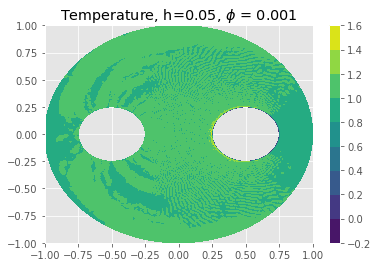

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 5.83e-14 rnorm 2.91e-15
Newton 1 anorm 1.12e-11 rnorm 1.54e-13


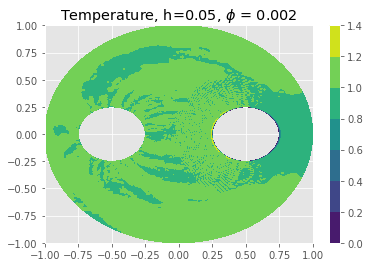

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 5.87e-14 rnorm 2.93e-15
Newton 1 anorm 7.51e-12 rnorm 1.31e-13


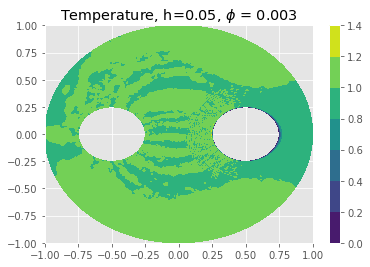

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 5.82e-14 rnorm 2.91e-15
Newton 1 anorm 5.56e-12 rnorm 1.12e-13


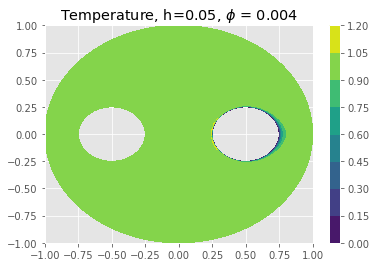

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 5.87e-14 rnorm 2.93e-15
Newton 1 anorm 4.43e-12 rnorm 9.79e-14


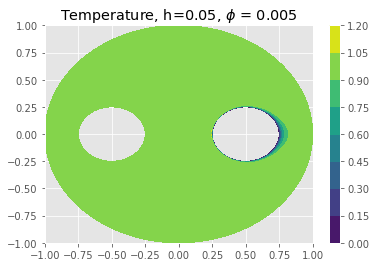

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 5.89e-14 rnorm 2.94e-15
Newton 1 anorm 3.73e-12 rnorm 8.81e-14


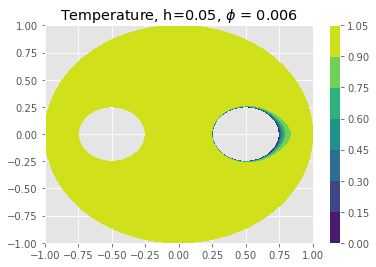

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 6.01e-14 rnorm 3.00e-15
Newton 1 anorm 3.20e-12 rnorm 7.93e-14


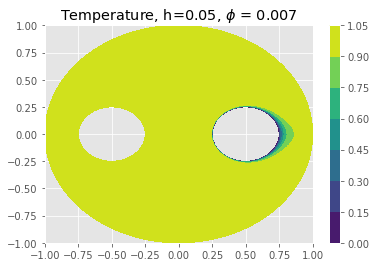

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 5.81e-14 rnorm 2.91e-15
Newton 1 anorm 2.80e-12 rnorm 7.22e-14


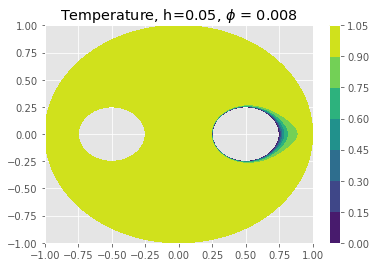

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 5.87e-14 rnorm 2.93e-15
Newton 1 anorm 2.50e-12 rnorm 6.64e-14


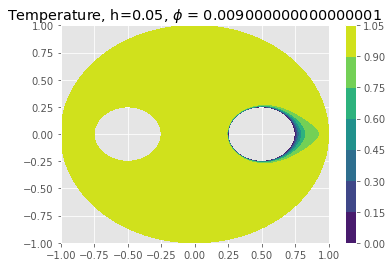

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 5.89e-14 rnorm 2.94e-15
Newton 1 anorm 2.23e-12 rnorm 6.06e-14


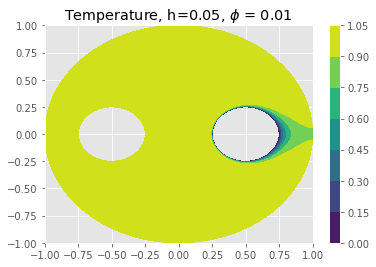

In [70]:
phi_all = numpy.linspace(0.001,0.01, 10)
h = 0.05
for j,phi in enumerate(phi_all):
#     m_temp = numpy.empty(len(h))
#     for i, h_i in enumerate(h):
    mesh = Mesh(shape='eyes', lcar=h, reshape_boundary=True)

    prob = laplacian_pressure()
    x, pressure = fe2_solve(fe, mesh, prob.form, 
                            dirichlet=dict(left=lambda x:0*x[:,0]+1, right=lambda x:0*x[:,0]))

    prob_t = laplacian_temperature(k = 1, phi = phi)
    x, temperature = fe2_solve(fe, mesh, prob_t.form, pres=pressure,
                           dirichlet=dict(left=lambda x:0*x[:,0]+1, right=lambda x:0*x[:,0]))
    pyplot.tricontourf(x[:,0], x[:,1], temperature, triangles=mesh.tri2())
    pyplot.title('Temperature, h={}, $\phi$ = {}'.format(h,phi))
    pyplot.colorbar();
    pyplot.show()

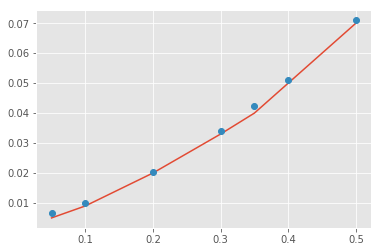

In [99]:
x = [0.05, 0.1, 0.2, 0.3, 0.35, 0.4, 0.5]
y = [0.005, 0.009, 0.02, 0.033, 0.04, 0.05, 0.07]
pyplot.plot(x,y)
pyplot.plot(x, 1/5*numpy.power(x, 1.6)+0.005,'o');
pyplot.show()

There is definitely dependence between grid size and minimum resolved permeability. 